#Imports


In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install datasets -q
!pip install tokenizers -q
!pip install transformers -q
!pip install seqeval -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-nc6v7xop
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-nc6v7xop
  Resolved https://github.com/csebuetnlp/normalizer to commit d80c3c484e1b80268f2b2dfaf7557fe65e34f321
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6877 sha256=9e928e3edf68d5f17df1fed865283cd03488b4032223c11bc012d03a8d640550
  Stored in directory: /tmp/pip-ephem-wheel-cache-evr7wfvd/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from normalizer import normalize
import torch
from transformers import ElectraTokenizer, ElectraForPreTraining, ElectraForTokenClassification, AdamW
from transformers import pipeline, AutoTokenizer, AutoModelForPreTraining , BertModel
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle

# DataLoader


#Gazetteer Trie


In [ ]:
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False

class Trie:
    def __init__(self):
        self.root = TrieNode()
        self.entity_tags = ["PER", "LOC", "CW", "CORP", "GRP", "PROD"]
        self.tag_encoding = {"O": 0, "B-PER": 1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4,
                             "B-CW": 5, "I-CW": 6, "B-CORP": 7, "I-CORP": 8, 
                             "B-GRP": 9, "I-GRP": 10, "B-PROD": 11, "I-PROD": 12}

    def insert(self, word, entity_type):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end_of_word = True
        node.entity_type = entity_type

    def search(self, sentence):
        encoding = [0] * len(sentence)
        for i in range(len(sentence)):
            node = self.root
            for j in range(i, len(sentence)):
                char = sentence[j]
                if char not in node.children:
                    break
                node = node.children[char]
                if node.is_end_of_word:
                    entity_type = node.entity_type
                    entity_length = j - i + 1
                    start_index = i
                    end_index = j
                    for k in range(start_index, end_index + 1):
                        if k == start_index:
                            encoding[k] = self.tag_encoding["B-" + entity_type]
                        else:
                            encoding[k] = self.tag_encoding["I-" + entity_type]
                    break
        one_hot_encoding = [[0] * 13 for i in range(len(encoding))]
        for i, tag in enumerate(encoding):
            one_hot_encoding[i][tag] = 1
        return one_hot_encoding

import numpy as np

def group_encodings_by_word(encoding, sentence):
    # Create an empty list to store the word encodings
    word_encodings = []
    
    # Create an empty list to store the current word encoding
    current_word_encoding = []
    
    # Create an empty string to store the current word
    current_word = ""
    
    # Iterate over each character encoding and character in the input encoding list and sentence, respectively
    for char_encoding, char in zip(encoding, sentence):
        # If the current character is a whitespace character, finish the current word and add its first character encoding to the word encodings list
        if char == " ":
            if len(current_word_encoding) > 0:
                word_encodings.append(np.array(current_word_encoding[0]))
                current_word_encoding = []
            current_word = ""
        # If the current character is part of a word, append the character encoding to the current word encoding and the character to the current word
        else:
            current_word_encoding.append(char_encoding)
            current_word += char
    
    # Add the last word encoding to the word encodings list, if it exists
    if len(current_word_encoding) > 0:
        word_encodings.append(np.array(current_word_encoding[0]))
    
    # Return the word encodings as a NumPy array
    return torch.from_numpy(np.array(word_encodings)).type(torch.float32)



def save_trie(trie, filename):
    with open(filename, "wb") as f:
        pickle.dump(trie, f)

def load_trie(filename):
    with open(filename, "rb") as f:
        trie = pickle.load(f)
    return trie


In [ ]:
def Gtoken(text):
  inputs = tokenizer.encode_plus(text, return_tensors='pt')

  encoded_dict = tokenizer.encode_plus(
                  text,       # Sentence to encode.
                  add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                  max_length = 314,           # Pad & truncate all sentences.
                  padding = 'max_length',
                  return_attention_mask = True,   # Construct attn. masks.
                  return_tensors = 'pt',
                  truncation=False)
  input_ids = encoded_dict['input_ids']
  tokenized = tokenizer.convert_ids_to_tokens([i.item() for i in input_ids.squeeze() if i > 1])
  return "< "+" ".join(tokenized)+" >"

# Trie INIT


We don't need it since it is already initialized in Trie.bin


In [ ]:
# tree = Trie()
# entity_tags = ["PER", "LOC", "CW", "CORP", "GRP", "PROD"]
# for entity in entity_tags:
#     with open('KE/{}/{}.txt'.format(entity,entity), 'r', encoding = 'utf-8') as file:
#         print(entity)
#         for line in file:
#             tree.insert(Gtoken(normalize(line.strip())), entity)
#     with open('KE/{}.txt'.format(entity), 'r', encoding = 'utf-8') as file:
#         print(entity)
#         for line in file:
#             tree.insert(Gtoken(normalize(line.strip())), entity)

# save_trie(tree, "Trie.bin")


In [ ]:
%cd /content/drive/MyDrive/Bracu/THESIS/Trie DS/

/content/drive/MyDrive/Bracu/THESIS/Trie DS


#Loading Gazetteer

In [ ]:
# Trie.bin Link: https://drive.google.com/file/d/1DXUPv8KmGiko5iijvnd93rRL-C86Yty6/view?usp=sharing

trie = load_trie('Trie.bin')

In [ ]:
# model Link= "https://drive.google.com/drive/folders/1IOxlGkATxG4RTgv7f4942msTMYtWgva6?usp=share_link"

model_name = '/content/drive/MyDrive/Thesis/BERTOUTPUT/checkpoint-11000/'
tokenizer = ElectraTokenizer.from_pretrained(model_name)

In [ ]:

sentence = Gtoken(normalize("২০১৮ এর সেরা বর্ণানুক্রমিকভাবে তালিকাভুক্ত র‍্যাঙ্ক করা হয়নি এনপিআর"))
encoding = trie.search(sentence)
# for i, word in enumerate(sentence):
#     # print(encoding[i],word)

word_encodings = group_encodings_by_word(encoding,sentence)

# Print the word encodings
for word, word_encoding in zip(sentence.split(), word_encodings):
    print(word, word_encoding)

print(word_encodings.size())

< tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
২০১৮ tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
এর tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
সেরা tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
বর্ণা tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
##নু tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
##ক্রম tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
##িকভাবে tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
তালিকাভুক্ত tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
র্যাঙ্ক tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
করা tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
হয়নি tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
এন tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
##পি tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
##আর tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
def Gazetteer(sentence):
  sentence = Gtoken(normalize(sentence))
  encoding = trie.search(sentence)
  return group_encodings_by_word(encoding,sentence)

In [ ]:
Gazetteer("২০১৮ এর সেরা বর্ণানুক্রমিকভাবে তালিকাভুক্ত র‍্যাঙ্ক করা হয়নি এনপিআর")

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

#Model




In [ ]:
# model Link= "https://drive.google.com/drive/folders/1IOxlGkATxG4RTgv7f4942msTMYtWgva6?usp=share_link"

# model_name = '/content/drive/MyDrive/Thesis/BERTOUTPUT/checkpoint-11000/'
# tokenizer = ElectraTokenizer.from_pretrained(model_name)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# OUR PROPOSED MODEL

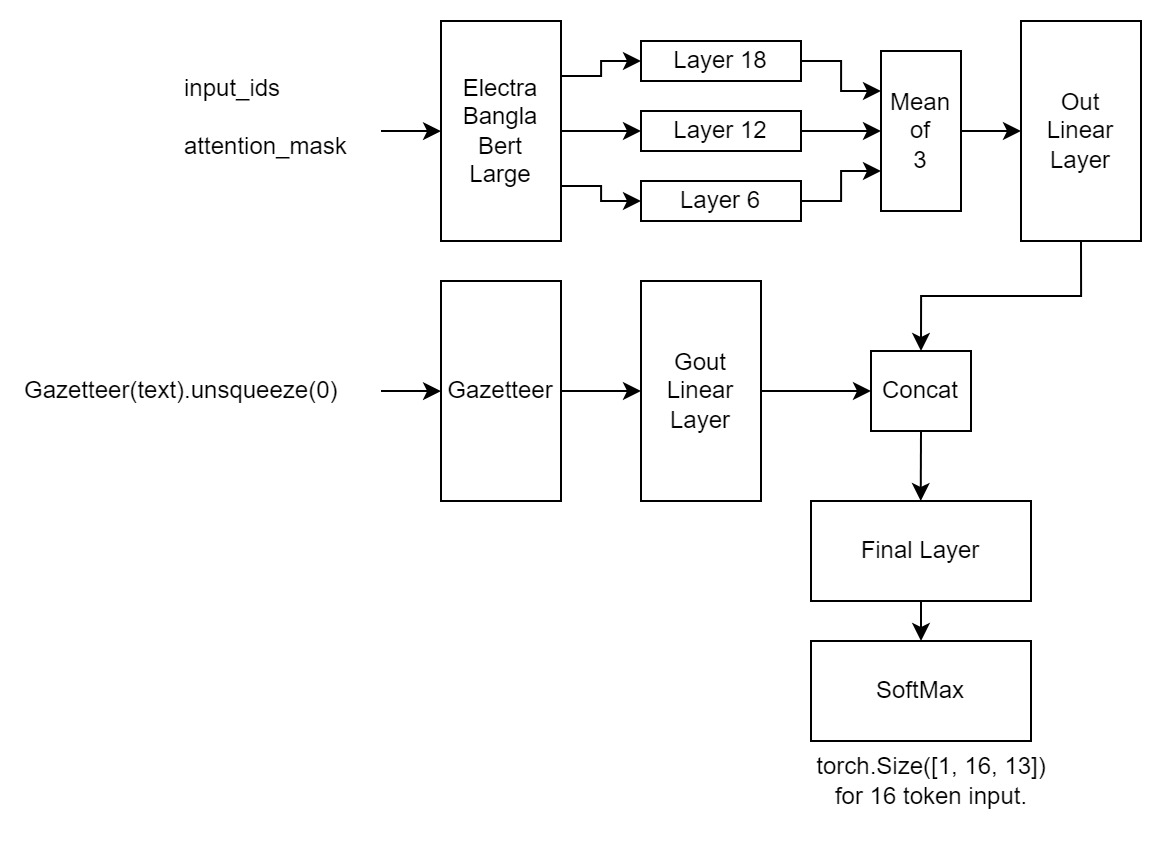

In [ ]:
class NERClassification(nn.Module):
  def __init__(self, n_classes):
    super(NERClassification, self).__init__()
    self.bert = ElectraForTokenClassification.from_pretrained(model_name, output_hidden_states=True)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.gOut = nn.Linear(n_classes,n_classes)
    self.final_out = nn.Linear(2*n_classes, n_classes)
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, input_ids, attention_mask, gazetteer):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    hidden_states = pooled_output.hidden_states

    # print(hidden_states)
    
    layer6 = hidden_states[6]
    layer12 = hidden_states[12]
    layer18 = hidden_states[18]


    averaged_hidden_states = torch.mean(torch.stack([layer6, layer12, layer18]), dim=0)

    # print(pooled_output)

    output = self.drop(averaged_hidden_states)
    output = self.out(output)
    goutput = self.gOut(gazetteer)
    final_output = torch.concat((output,goutput), dim = 2)
    final_output = self.final_out(final_output)
    final_output = self.softmax(final_output)
    return final_output

In [ ]:
model = NERClassification(n_classes=13)

In [ ]:
# Tokenize the sentence


transformers.tokenization_utils_base.BatchEncoding

In [ ]:


text = "সিনেমায় গানটির বৈশিষ্ট্য রয়েছে রাস্তা যাত্রা ।"
inputs = tokenizer(text, return_tensors='pt')

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
gazetteer = Gazetteer(text).unsqueeze(0)
# Run the model
outputs = model(input_ids=input_ids, attention_mask=attention_mask, gazetteer = gazetteer)

print(outputs.size())

# Get the predicted label
x, predicted_label = torch.max(outputs, dim=2)

predicted_label

# Print the predicted label
# print(predicted_label.item())

torch.Size([1, 9, 13])


tensor([[ 7,  6, 11, 11, 11,  9,  8,  4,  6]])

In [ ]:
x

tensor([[0.1146, 0.1382, 0.1297, 0.1328, 0.1237, 0.1303, 0.1500, 0.1246, 0.1193]],
       grad_fn=<MaxBackward0>)

In [ ]:
outputs[0]

tensor([[0.0982, 0.0971, 0.1181, 0.1122, 0.1040, 0.1026, 0.1042, 0.1110, 0.0987,
         0.1118, 0.1230, 0.1015, 0.1034],
        [0.1169, 0.1181, 0.1225, 0.1140, 0.1079, 0.1147, 0.1342, 0.1253, 0.1181,
         0.1061, 0.1073, 0.1204, 0.1054],
        [0.1258, 0.1065, 0.1210, 0.1028, 0.1071, 0.1130, 0.1097, 0.1070, 0.1158,
         0.1051, 0.1182, 0.1070, 0.1209],
        [0.0967, 0.1295, 0.1090, 0.1287, 0.0987, 0.1297, 0.1033, 0.1081, 0.0975,
         0.1079, 0.0959, 0.1541, 0.1251],
        [0.1028, 0.1104, 0.1152, 0.1049, 0.1171, 0.1058, 0.1171, 0.1124, 0.0864,
         0.1163, 0.1136, 0.1190, 0.0953],
        [0.1049, 0.1110, 0.1017, 0.1038, 0.1102, 0.1140, 0.1243, 0.1209, 0.0928,
         0.1245, 0.1124, 0.1040, 0.0980],
        [0.1256, 0.1126, 0.0918, 0.1175, 0.1214, 0.0898, 0.0875, 0.0891, 0.1593,
         0.1092, 0.1158, 0.0952, 0.1230],
        [0.1220, 0.1130, 0.1054, 0.1043, 0.1288, 0.1097, 0.1009, 0.1084, 0.1274,
         0.1048, 0.1000, 0.0993, 0.1183],
        [0.1070,

We need to train the model.

# Dataset Load

In [ ]:
#Link : https://drive.google.com/drive/folders/13SA1s2v1R8PHBRytNKP7UR4_8WU8SKjF?usp=share_link

In [ ]:
%cd /content/drive/MyDrive/Bracu/THESIS/DatasetSir

/content/drive/MyDrive/Bracu/THESIS/DatasetSir


In [ ]:
# Load the NER dataset
df_train = pd.read_csv('trainData2022PP2.csv')
df_val = pd.read_csv('devData2022PP2.csv')
df_test = pd.read_csv('testData2022PP2.csv')

In [ ]:
d = {'O': 0, 'B-CORP': 1, 'I-CORP': 2, 'B-CW': 3, 'I-CW': 4, 'B-GRP': 5, 'I-GRP': 6, 'B-LOC': 7, 'I-LOC': 8, 'B-PER': 9, 'I-PER': 10, 'B-PROD': 11, 'I-PROD': 12}
def label_encoder(x):
    x = eval(x)
    y = []
    for i in x:
      y.append(d[i])
    return y
df_train['Tag'] = df_train['Tag'].apply(lambda x: label_encoder(x))
df_test['Tag'] = df_test['Tag'].apply(lambda x: label_encoder(x))
df_val['Tag'] = df_val['Tag'].apply(lambda x: label_encoder(x))
df_train.head()

,Sentence #,Word,Tag
0,Sentence: 1,২০১৮ এর সেরা বর্ণানুক্রমিকভাবে তালিকাভুক্ত র‍্...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,Sentence: 10,সিনেমায় গানটির বৈশিষ্ট্য রয়েছে রাস্তা যাত্রা ।,"[0, 0, 0, 0, 3, 4, 0]"
2,Sentence: 100,করে বাদ্যযন্ত্রের থিম এবং চলচ্চিত্রের জন্য প্র...,"[5, 0, 0, 0, 0, 0, 0, 0]"
3,Sentence: 1000,প্রতিষ্ঠান ২২১১ ইঙ্গিত করে যে আউগুস্তুস পৃথক ক...,"[0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Sentence: 10000,শো স্টপারে তাদের বেকড আলাস্কা করতে সাড়ে চার ঘ...,"[0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0]"


In [ ]:
def tokenized_df(text):
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs['input_ids']
    return input_ids

def tokenized_df1(text):
    inputs = tokenizer(text, return_tensors='pt')
    attention_mask = inputs['attention_mask']
    return attention_mask
def tokenized_df2(text):
    gazetteer = Gazetteer(text).unsqueeze(0)
    return gazetteer
  
# df_val['input'] = df_val['Word'].apply(lambda x: tokenized_df(x))
# df_train['input'] = df_train['Word'].apply(lambda x: tokenized_df(x))


In [ ]:
df_val['input_ids'] =  df_val['Word'].apply(lambda x: tokenized_df(x))
df_val['attention_mask'] =  df_val['Word'].apply(lambda x: tokenized_df1(x))
df_val['gazetteer'] =  df_val['Word'].apply(lambda x: tokenized_df2(x))
df_train['input_ids'] = df_train['Word'].apply(lambda x: tokenized_df(x))
df_train['attention_mask'] = df_train['Word'].apply(lambda x: tokenized_df1(x))
df_train['gazetteer'] = df_train['Word'].apply(lambda x: tokenized_df2(x))

In [ ]:
df_train.head()

,Sentence #,Word,Tag,input_ids,attention_mask,gazetteer
0,Sentence: 1,২০১৮ এর সেরা বর্ণানুক্রমিকভাবে তালিকাভুক্ত র‍্...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]","[[tensor(2), tensor(7349), tensor(919), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."
1,Sentence: 10,সিনেমায় গানটির বৈশিষ্ট্য রয়েছে রাস্তা যাত্রা ।,"[0, 0, 0, 0, 3, 4, 0]","[[tensor(2), tensor(13509), tensor(20928), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."
2,Sentence: 100,করে বাদ্যযন্ত্রের থিম এবং চলচ্চিত্রের জন্য প্র...,"[5, 0, 0, 0, 0, 0, 0, 0]","[[tensor(2), tensor(792), tensor(31661), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."
3,Sentence: 1000,প্রতিষ্ঠান ২২১১ ইঙ্গিত করে যে আউগুস্তুস পৃথক ক...,"[0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0]","[[tensor(2), tensor(2857), tensor(3312), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."
4,Sentence: 10000,শো স্টপারে তাদের বেকড আলাস্কা করতে সাড়ে চার ঘ...,"[0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0]","[[tensor(2), tensor(3057), tensor(22353), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."


In [ ]:
df_train['Word'][0][:]

'২০১৮ এর সেরা বর্ণানুক্রমিকভাবে তালিকাভুক্ত র\u200d্যাঙ্ক করা হয়নি এনপিআর'

In [ ]:
from transformers import TrainingArguments, Trainer


In [ ]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
args = TrainingArguments(
    f"Amader NER MODEL",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)